In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
def weighted_euclidean_distance(p, q, weights):
    return np.sqrt(np.sum(weights * (p - q) ** 2))

In [3]:
from sklearn.neighbors import NearestNeighbors

In [4]:
def weighted_adasyn(X, y, beta=1.0, k=5, weights=None):
    X_min = X[y == 1]
    X_maj = X[y == 0]

    n_min, n_maj = len(X_min), len(X_maj)
    G = (n_maj - n_min) * beta  # number of synthetic samples

    synthetic_samples = []
    y_synthetic = []

    nn = NearestNeighbors(n_neighbors=k).fit(X)
    for xi in X_min:
        distances, indices = nn.kneighbors([xi])
        for idx in indices[0]:
            if y[idx] == 0:
                continue
            xj = X[idx]
            lam = np.random.rand()
            diff = (xj - xi)
            if weights is not None:
                diff = diff * np.sqrt(weights)
            synthetic = xi + lam * diff
            synthetic_samples.append(synthetic)
            y_synthetic.append(1)
            if len(synthetic_samples) >= G:
                break
        if len(synthetic_samples) >= G:
            break

    if len(synthetic_samples) > 0:
        X_new = np.vstack([X, synthetic_samples])
        y_new = np.hstack([y, y_synthetic])
    else:
        X_new, y_new = X, y

    return X_new, y_new

In [ ]:
df = pd.read_csv("onlinefraud.csv")

In [6]:
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [7]:
# df = df.sample(3000000, random_state=42)

In [8]:
X = df.drop("isFraud", axis=1).values
y = df["isFraud"].values

In [9]:
feature_weights = np.ones(X.shape[1]) 
X_resampled, y_resampled = weighted_adasyn(X, y, beta=0.8, k=5, weights=feature_weights)

print("Before ADASYN:", np.bincount(y))
print("After ADASYN :", np.bincount(y_resampled))

Before ADASYN: [6354407    8213]
After ADASYN : [6354407   34643]


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [20]:
data = {
    'Before ADASYN': [6354407, 8213],
    'After ADASYN': [6354407, 34643]
}
counts_df = pd.DataFrame(data, index=['Class 0', 'Class 1'])

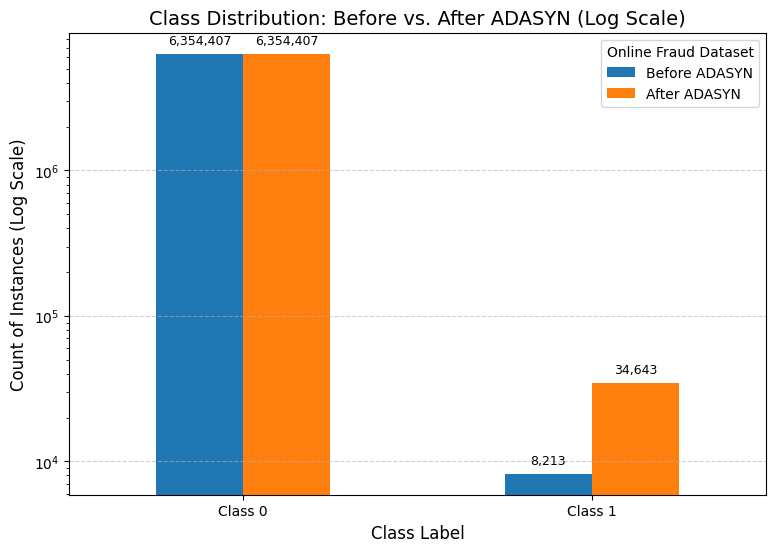

In [21]:
plt.figure(figsize=(9, 6))
ax = counts_df.plot(
    kind='bar', 
    logy=True, 
    figsize=(9, 6),
    color=['#1f77b4', '#ff7f0e'],
    ax=plt.gca()
)

plt.title('Class Distribution: Before vs. After ADASYN (Log Scale)', fontsize=14)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Count of Instances (Log Scale)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Online Fraud Dataset', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adding count labels
for container in ax.containers:
    for i, bar in enumerate(container):
        label = f'{bar.get_height():,.0f}'
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.1, label, 
                 ha='center', va='bottom', fontsize=9)
        
plt.show() 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42
)

In [ ]:
cart = DecisionTreeClassifier(
    criterion="gini",       # standard Gini (approximating Regularized Gini)
    max_depth=5,            # limits tree growth (stability)
    min_samples_split=10,   
    min_samples_leaf=5,    
    ccp_alpha=0.001,        # cost-complexity pruning (acts like λ·Complexity(T))
    random_state=42
)

In [12]:
ada_cart = AdaBoostClassifier(
    estimator=cart,
    n_estimators=50,
    learning_rate=0.5,
    random_state=42
)

In [13]:
ada_cart.fit(X_train, y_train)
y_pred = ada_cart.predict(X_test)

In [14]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9993113217144959


In [15]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.89      0.93     10393

    accuracy                           1.00   1916715
   macro avg       0.99      0.94      0.97   1916715
weighted avg       1.00      1.00      1.00   1916715



In [22]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report = df_report.drop(columns=['support'])
df_plot = df_report.iloc[[0, 1]][['precision', 'recall', 'f1-score']]

<Axes: >

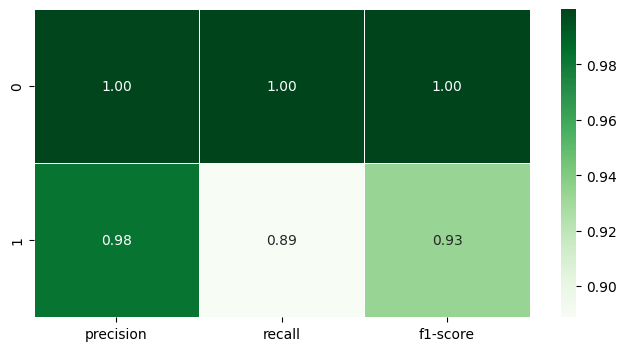

In [29]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    df_plot,
    annot=True,            # Show the numeric value in each cell
    fmt=".2f",             # Format to 2 decimal places
    cmap="Greens",         
    cbar=True,             # Display the color bar
    linewidths=.5,         # Add lines for separation
)

In [16]:
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Confusion Matrix:
 [[1906158     164]
 [   1156    9237]]
